Using device: cpu
EMOJI GENERATIVE AI MODEL

1. Loading and preprocessing dataset...
Loading emoji dataset from Hugging Face...


dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

Loaded 2749 images
✓ Dataset loaded successfully: 2749 images

Do you want to train a new model? (y/n): y

2. Training VAE model...
Loading emoji dataset from Hugging Face...
Loaded 2749 images
Starting training for 50 epochs...
Epoch: 0 [0/2749 (0%)]	Loss: 10858.975586
====> Epoch: 0 Average loss: 6771.6512
Epoch: 1 [0/2749 (0%)]	Loss: 2950.454346
====> Epoch: 1 Average loss: 2363.4194
Epoch: 2 [0/2749 (0%)]	Loss: 2080.592773
====> Epoch: 2 Average loss: 1862.5583
Epoch: 3 [0/2749 (0%)]	Loss: 1694.043823
====> Epoch: 3 Average loss: 1645.6206
Epoch: 4 [0/2749 (0%)]	Loss: 1488.164307
====> Epoch: 4 Average loss: 1491.7091
Epoch: 5 [0/2749 (0%)]	Loss: 1538.416016
====> Epoch: 5 Average loss: 1385.2335
Epoch: 6 [0/2749 (0%)]	Loss: 1303.759033
====> Epoch: 6 Average loss: 1296.3352
Epoch: 7 [0/2749 (0%)]	Loss: 1198.774536
====> Epoch: 7 Average loss: 1227.3371
Epoch: 8 [0/2749 (0%)]	Loss: 1147.891968
====> Epoch: 8 Average loss: 1178.6100
Epoch: 9 [0/2749 (0%)]	Loss: 1202.747070
====> Epo

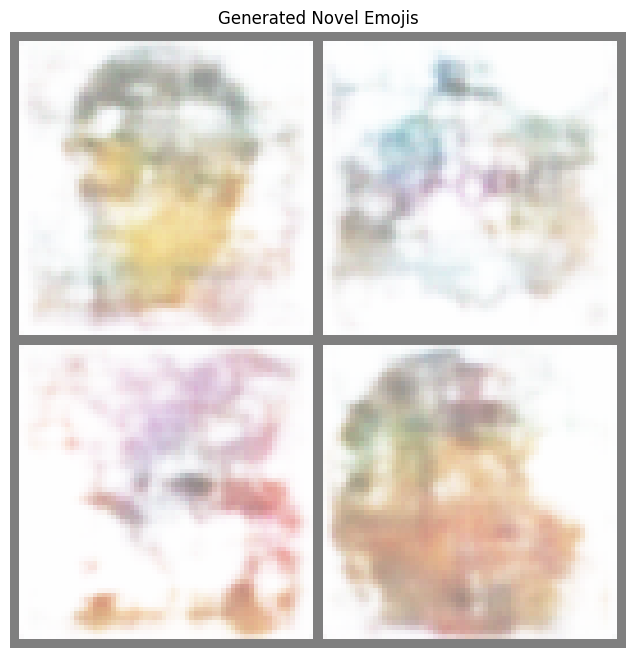


4. Performing interpolation between emojis...
Loading emoji dataset from Hugging Face...
Loaded 2749 images


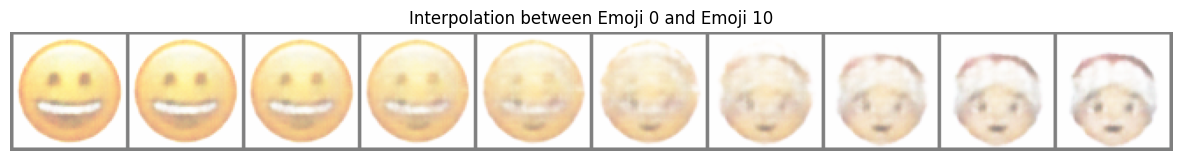

✓ Interpolation completed and saved!

All tasks completed successfully!
Check './emoji_model' for generated images and model files


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import requests
import zipfile
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==================== Configuration ====================
CONFIG = {
    "image_size": 64,
    "batch_size": 64,
    "latent_dim": 256,
    "learning_rate": 0.001,
    "num_epochs": 50,
    "save_dir": "./emoji_model",
    "num_generated": 4  # For 2x2 grid
}

# Create save directory
os.makedirs(CONFIG["save_dir"], exist_ok=True)

# ==================== Dataset Loading and Preprocessing ====================
class EmojiDataset(Dataset):
    def __init__(self, image_size=64):
        super().__init__()
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])

        # Load dataset from Hugging Face
        print("Loading emoji dataset from Hugging Face...")
        self.dataset = load_dataset("valhalla/emoji-dataset", split="train")
        print(f"Loaded {len(self.dataset)} images")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]

        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        return self.transform(image)

# ==================== VAE Model Architecture ====================
class VAE(nn.Module):
    def __init__(self, latent_dim=256, image_size=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 64x64 -> 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 32x32 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )

        # Latent space
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 4x4 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # 32x32 -> 64x64
            nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss

# ==================== Training Function ====================
def train_vae():
    # Create dataset and dataloader
    dataset = EmojiDataset(image_size=CONFIG["image_size"])
    dataloader = DataLoader(dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=4)

    # Initialize model
    model = VAE(latent_dim=CONFIG["latent_dim"], image_size=CONFIG["image_size"]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])

    print(f"Starting training for {CONFIG['num_epochs']} epochs...")

    for epoch in range(CONFIG["num_epochs"]):
        model.train()
        train_loss = 0

        for batch_idx, data in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} '
                      f'({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

        avg_loss = train_loss / len(dataloader.dataset)
        print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f'{CONFIG["save_dir"]}/vae_checkpoint_epoch_{epoch+1}.pth')

            # Generate sample images
            generate_new_emojis(model, epoch+1)

    # Save final model
    torch.save(model.state_dict(), f'{CONFIG["save_dir"]}/vae_final.pth')
    return model

# ==================== Generate New Emojis Function ====================
def generate_new_emojis(model=None, epoch=None):
    """Generate a 2x2 grid of novel emojis"""
    if model is None:
        # Load trained model
        model = VAE(latent_dim=CONFIG["latent_dim"], image_size=CONFIG["image_size"]).to(device)
        model.load_state_dict(torch.load(f'{CONFIG["save_dir"]}/vae_final.pth'))

    model.eval()

    with torch.no_grad():
        # Generate random latent vectors
        z = torch.randn(CONFIG["num_generated"], CONFIG["latent_dim"]).to(device)

        # Decode to images
        generated = model.decode(z)

        # Create 2x2 grid
        grid = utils.make_grid(generated, nrow=2, normalize=True, padding=2)

        # Convert to numpy for display
        grid_np = grid.cpu().numpy().transpose(1, 2, 0)

        # Denormalize
        grid_np = (grid_np + 1) / 2
        grid_np = np.clip(grid_np, 0, 1)

        # Plot
        plt.figure(figsize=(8, 8))
        plt.imshow(grid_np)
        plt.axis('off')

        # Save if epoch is provided
        if epoch:
            plt.title(f'Generated Emojis - Epoch {epoch}')
            plt.savefig(f'{CONFIG["save_dir"]}/generated_epoch_{epoch}.png', bbox_inches='tight', pad_inches=0)
            plt.close()
        else:
            plt.title('Generated Novel Emojis')
            plt.show()

        return generated

# ==================== Interpolation Function ====================
def interpolate_emojis(model=None, emoji1_idx=0, emoji2_idx=1, num_steps=10):
    """
    Interpolate between two emojis and generate intermediate images

    Args:
        model: Trained VAE model
        emoji1_idx: Index of first emoji in dataset
        emoji2_idx: Index of second emoji in dataset
        num_steps: Number of interpolation steps
    """
    if model is None:
        # Load trained model
        model = VAE(latent_dim=CONFIG["latent_dim"], image_size=CONFIG["image_size"]).to(device)
        model.load_state_dict(torch.load(f'{CONFIG["save_dir"]}/vae_final.pth'))

    # Load dataset
    dataset = EmojiDataset(image_size=CONFIG["image_size"])
    dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

    # Get two emojis
    all_data = []
    for data in dataloader:
        all_data.append(data)
        if len(all_data) >= max(emoji1_idx, emoji2_idx) // 2 + 1:
            break

    emoji1 = all_data[emoji1_idx // 2][emoji1_idx % 2].unsqueeze(0).to(device)
    emoji2 = all_data[emoji2_idx // 2][emoji2_idx % 2].unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        # Encode both emojis to latent space
        mu1, logvar1 = model.encode(emoji1)
        mu2, logvar2 = model.encode(emoji2)

        # Linear interpolation in latent space
        interpolated_images = []

        for i in range(num_steps):
            alpha = i / (num_steps - 1)  # 0 to 1

            # Interpolate between latent vectors
            z_interp = (1 - alpha) * mu1 + alpha * mu2

            # Decode interpolated latent vector
            interp_img = model.decode(z_interp)
            interpolated_images.append(interp_img.squeeze())

    # Create grid of interpolated images
    grid = utils.make_grid(interpolated_images, nrow=num_steps, normalize=True, padding=2)

    # Convert to numpy for display
    grid_np = grid.cpu().numpy().transpose(1, 2, 0)

    # Denormalize
    grid_np = (grid_np + 1) / 2
    grid_np = np.clip(grid_np, 0, 1)

    # Plot
    plt.figure(figsize=(15, 3))
    plt.imshow(grid_np)
    plt.axis('off')
    plt.title(f'Interpolation between Emoji {emoji1_idx} and Emoji {emoji2_idx}')
    plt.savefig(f'{CONFIG["save_dir"]}/interpolation_{emoji1_idx}_to_{emoji2_idx}.png',
                bbox_inches='tight', pad_inches=0)
    plt.show()

    # Save individual interpolation images
    os.makedirs(f'{CONFIG["save_dir"]}/interpolation_frames', exist_ok=True)
    for i, img_tensor in enumerate(interpolated_images):
        img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)
        img_np = (img_np + 1) / 2
        img_np = np.clip(img_np * 255, 0, 255).astype(np.uint8)

        img = Image.fromarray(img_np)
        img.save(f'{CONFIG["save_dir"]}/interpolation_frames/frame_{i:03d}.png')

    return interpolated_images

# ==================== Main Execution ====================
def main():
    print("=" * 60)
    print("EMOJI GENERATIVE AI MODEL")
    print("=" * 60)

    # Check if dataset is already available
    print("\n1. Loading and preprocessing dataset...")
    try:
        dataset = EmojiDataset(image_size=CONFIG["image_size"])
        print(f"✓ Dataset loaded successfully: {len(dataset)} images")
    except Exception as e:
        print(f"✗ Error loading dataset: {e}")
        return

    # Train or load model
    train_new = input("\nDo you want to train a new model? (y/n): ").lower().strip() == 'y'

    if train_new:
        print("\n2. Training VAE model...")
        model = train_vae()
        print("✓ Training completed!")
    else:
        print("\n2. Loading pre-trained model...")
        model = VAE(latent_dim=CONFIG["latent_dim"], image_size=CONFIG["image_size"]).to(device)
        try:
            model.load_state_dict(torch.load(f'{CONFIG["save_dir"]}/vae_final.pth'))
            print("✓ Model loaded successfully!")
        except:
            print("✗ No pre-trained model found. Please train a model first.")
            return

    # Generate new emojis
    print("\n3. Generating novel emojis (2x2 grid)...")
    generate_new_emojis(model)

    # Perform interpolation
    print("\n4. Performing interpolation between emojis...")
    try:
        interpolate_emojis(model, emoji1_idx=0, emoji2_idx=10, num_steps=10)
        print("✓ Interpolation completed and saved!")
    except Exception as e:
        print(f"✗ Error during interpolation: {e}")

    print("\n" + "=" * 60)
    print("All tasks completed successfully!")
    print(f"Check '{CONFIG['save_dir']}' for generated images and model files")
    print("=" * 60)

# ==================== Utility Functions ====================
def quick_generate():
    """Quick function to generate emojis without training"""
    print("Loading model and generating emojis...")

    # Load model
    model = VAE(latent_dim=CONFIG["latent_dim"], image_size=CONFIG["image_size"]).to(device)

    try:
        model.load_state_dict(torch.load(f'{CONFIG["save_dir"]}/vae_final.pth',
                                        map_location=device))
        model.eval()
        print("Model loaded successfully!")
    except:
        print("No trained model found. Please run main() to train a model first.")
        return

    # Generate
    generate_new_emojis(model)

    # Interpolate
    interpolate_input = input("Do you want to interpolate between emojis? (y/n): ").lower().strip()
    if interpolate_input == 'y':
        idx1 = int(input("Enter first emoji index (0-2499): "))
        idx2 = int(input("Enter second emoji index (0-2499): "))
        steps = int(input("Enter number of interpolation steps: "))
        interpolate_emojis(model, idx1, idx2, steps)

def quick_interpolation(emoji1_idx=0, emoji2_idx=100, num_steps=8):
    """Quick interpolation between two specific emojis"""
    print(f"Interpolating between emoji {emoji1_idx} and {emoji2_idx}...")

    # Load model
    model = VAE(latent_dim=CONFIG["latent_dim"], image_size=CONFIG["image_size"]).to(device)

    try:
        model.load_state_dict(torch.load(f'{CONFIG["save_dir"]}/vae_final.pth',
                                        map_location=device))
        model.eval()
        return interpolate_emojis(model, emoji1_idx, emoji2_idx, num_steps)
    except:
        print("No trained model found. Please run main() to train a model first.")
        return None

# Execute if run directly
if __name__ == "__main__":
    # Run the complete pipeline
    main()

    # Or use quick functions:


In [ ]:
quick_generate()  # For quick generation only
quick_interpolation(0, 100, 8)  # For quick interpolation

Using device: cuda
IMPROVED EMOJI VAE TRAINING
Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

Loaded 2749 images


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training Improved VAE for 200 epochs...
Latent dim: 128, Beta: 0.0001
Epoch 000 | Batch 000 | Loss: 0.6666 | Recon: 0.6666 | KL: 108.2865

Epoch 000 Summary:
  Total Loss:    0.4826
  Recon Loss:    0.4826 (per-pixel MSE)
  KL Loss:       6458.7704
  Current Beta:  0.000000
  Learning Rate: 0.000500

Epoch 001 | Batch 000 | Loss: 0.3652 | Recon: 0.3623 | KL: 1463.7283

Epoch 001 Summary:
  Total Loss:    0.3125
  Recon Loss:    0.3102 (per-pixel MSE)
  KL Loss:       1172.3843
  Current Beta:  0.000002
  Learning Rate: 0.000500

Epoch 002 | Batch 000 | Loss: 0.2691 | Recon: 0.2656 | KL: 876.5831

Epoch 002 Summary:
  Total Loss:    0.2420
  Recon Loss:    0.2394 (per-pixel MSE)
  KL Loss:       656.5868
  Current Beta:  0.000004
  Learning Rate: 0.000500

Epoch 003 | Batch 000 | Loss: 0.2194 | Recon: 0.2160 | KL: 557.8556

Epoch 003 Summary:
  Total Loss:    0.1976
  Recon Loss:    0.1946 (per-pixel MSE)
  KL Loss:       501.7376
  Current Beta:  0.000006
  Learning Rate: 0.000500

Epo

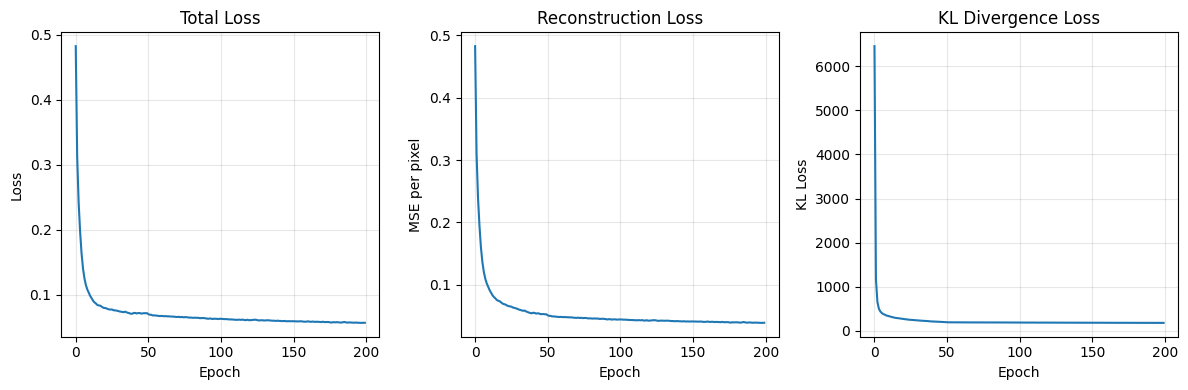


Evaluating model performance...
Loading dataset...
Loaded 2749 images

VAE PERFORMANCE EVALUATION
Average Reconstruction Loss (MSE): 0.038062
Average KL Divergence: 1.384971
Per-pixel RMSE: 0.1951

INTERPRETATION:
✓ Good reconstruction quality
○ KL loss is high - model might be ignoring latent space

Generating final outputs...


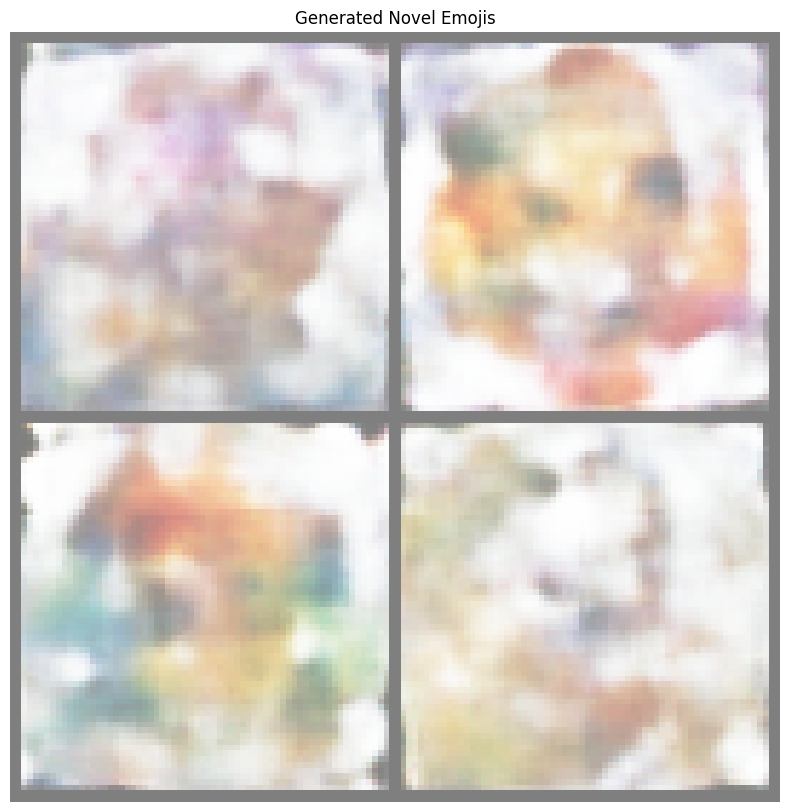

Loading dataset...
Loaded 2749 images


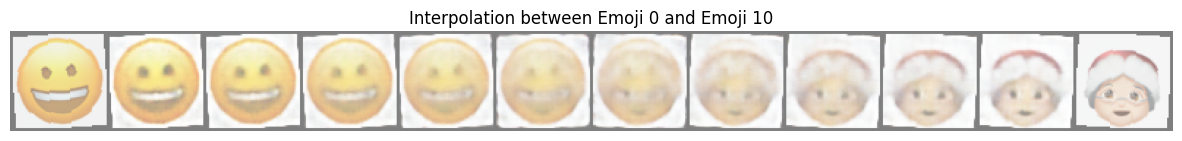


TRAINING COMPLETE!
Check './improved_emoji_model' for all outputs


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import os
from datasets import load_dataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==================== IMPROVED CONFIGURATION ====================
CONFIG = {
    "image_size": 64,
    "batch_size": 128,  # Increased batch size
    "latent_dim": 128,  # Reduced latent dimension (better for emojis)
    "learning_rate": 0.0005,  # Lower learning rate
    "num_epochs": 200,  # More epochs for better training
    "save_dir": "./improved_emoji_model",
    "beta": 0.0001,  # KL loss weight (very important!)
    "save_every": 20,
}

os.makedirs(CONFIG["save_dir"], exist_ok=True)

# ==================== IMPROVED DATASET ====================
class ImprovedEmojiDataset:
    def __init__(self, image_size=64):
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
            transforms.RandomRotation(degrees=10),   # Small rotations
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Color augmentation
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize per channel
        ])

        print("Loading dataset...")
        self.dataset = load_dataset("valhalla/emoji-dataset", split="train")
        print(f"Loaded {len(self.dataset)} images")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return self.transform(image)

# ==================== IMPROVED VAE ARCHITECTURE ====================
class ImprovedVAE(nn.Module):
    def __init__(self, latent_dim=128, image_size=64):
        super().__init__()
        self.latent_dim = latent_dim

        # ENCODER with more capacity
        self.encoder = nn.Sequential(
            # 64x64x3 -> 32x32x32
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # 32x32x32 -> 16x16x64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # 16x16x64 -> 8x8x128
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            # 8x8x128 -> 4x4x256
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Flatten()
        )

        # Calculate flattened size
        self.encoder_output_size = 256 * 4 * 4

        # Latent space
        self.fc_mu = nn.Linear(self.encoder_output_size, latent_dim)
        self.fc_logvar = nn.Linear(self.encoder_output_size, latent_dim)

        # DECODER
        self.decoder_input = nn.Linear(latent_dim, self.encoder_output_size)

        self.decoder = nn.Sequential(
            # 4x4x256 -> 8x8x128
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 8x8x128 -> 16x16x64
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # 16x16x64 -> 32x32x32
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # 32x32x32 -> 64x64x3
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# ==================== IMPROVED LOSS FUNCTION ====================
def improved_vae_loss(recon_x, x, mu, logvar, beta=CONFIG["beta"]):
    """
    Improved VAE loss with:
    1. Per-pixel normalized reconstruction loss
    2. Weighted KL divergence
    3. Better scaling
    """
    batch_size = x.size(0)

    # Reconstruction loss (per-pixel MSE, normalized by image size)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / batch_size
    recon_loss = recon_loss / (x.size(1) * x.size(2) * x.size(3))  # Normalize by number of pixels

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

    # Total loss with beta annealing
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

# ==================== IMPROVED TRAINING FUNCTION ====================
def train_improved_vae():
    dataset = ImprovedEmojiDataset(image_size=CONFIG["image_size"])
    dataloader = DataLoader(dataset, batch_size=CONFIG["batch_size"],
                          shuffle=True, num_workers=4, pin_memory=True)

    model = ImprovedVAE(latent_dim=CONFIG["latent_dim"],
                       image_size=CONFIG["image_size"]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"],
                          weight_decay=1e-5)  # Added weight decay

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                    factor=0.5, patience=10 )

    print(f"Training Improved VAE for {CONFIG['num_epochs']} epochs...")
    print(f"Latent dim: {CONFIG['latent_dim']}, Beta: {CONFIG['beta']}")

    train_losses = []
    recon_losses = []
    kl_losses = []

    for epoch in range(CONFIG["num_epochs"]):
        model.train()
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0

        # Optional: Beta annealing (increase beta gradually)
        current_beta = min(CONFIG["beta"] * (epoch / 50), CONFIG["beta"]) if epoch < 50 else CONFIG["beta"]

        for batch_idx, data in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            total_loss, recon_loss, kl_loss = improved_vae_loss(
                recon_batch, data, mu, logvar, beta=current_beta
            )

            total_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

            if batch_idx % 50 == 0:
                print(f'Epoch {epoch:03d} | Batch {batch_idx:03d} | '
                      f'Loss: {total_loss.item():.4f} | '
                      f'Recon: {recon_loss.item():.4f} | '
                      f'KL: {kl_loss.item():.4f}')

        # Calculate averages
        avg_total_loss = epoch_total_loss / len(dataloader)
        avg_recon_loss = epoch_recon_loss / len(dataloader)
        avg_kl_loss = epoch_kl_loss / len(dataloader)

        train_losses.append(avg_total_loss)
        recon_losses.append(avg_recon_loss)
        kl_losses.append(avg_kl_loss)

        # Update learning rate
        scheduler.step(avg_total_loss)

        print(f'\n{"="*60}')
        print(f'Epoch {epoch:03d} Summary:')
        print(f'  Total Loss:    {avg_total_loss:.4f}')
        print(f'  Recon Loss:    {avg_recon_loss:.4f} (per-pixel MSE)')
        print(f'  KL Loss:       {avg_kl_loss:.4f}')
        print(f'  Current Beta:  {current_beta:.6f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print(f'{"="*60}\n')

        # Save checkpoints and generate samples
        if (epoch + 1) % CONFIG["save_every"] == 0 or epoch == CONFIG["num_epochs"] - 1:
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_total_loss,
                'config': CONFIG
            }, f'{CONFIG["save_dir"]}/vae_epoch_{epoch+1}.pth')

            # Generate samples
            model.eval()
            with torch.no_grad():
                # Random generation
                z = torch.randn(4, CONFIG["latent_dim"]).to(device)
                generated = model.decode(z)

                # Interpolation
                z1 = torch.randn(1, CONFIG["latent_dim"]).to(device)
                z2 = torch.randn(1, CONFIG["latent_dim"]).to(device)
                interpolated = []
                for alpha in torch.linspace(0, 1, 8):
                    z_interp = (1 - alpha) * z1 + alpha * z2
                    interp_img = model.decode(z_interp)
                    interpolated.append(interp_img.squeeze())

                # Save images
                save_samples(generated, interpolated, epoch+1)

    # Plot loss curves
    plot_loss_curves(train_losses, recon_losses, kl_losses)

    return model

# ==================== SAMPLE GENERATION FUNCTIONS ====================
def save_samples(generated, interpolated, epoch):
    """Save generated and interpolated samples"""
    # Save random samples
    grid = utils.make_grid(generated, nrow=2, normalize=True, padding=2)
    grid_np = grid.cpu().numpy().transpose(1, 2, 0)
    grid_np = (grid_np + 1) / 2
    grid_np = np.clip(grid_np, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(grid_np)
    plt.axis('off')
    plt.title(f'Generated Emojis - Epoch {epoch}')
    plt.savefig(f'{CONFIG["save_dir"]}/generated_epoch_{epoch}.png',
                bbox_inches='tight', pad_inches=0, dpi=150)
    plt.close()

    # Save interpolation
    if interpolated:
        grid_interp = utils.make_grid(interpolated, nrow=8, normalize=True, padding=2)
        grid_interp_np = grid_interp.cpu().numpy().transpose(1, 2, 0)
        grid_interp_np = (grid_interp_np + 1) / 2
        grid_interp_np = np.clip(grid_interp_np, 0, 1)

        plt.figure(figsize=(12, 2))
        plt.imshow(grid_interp_np)
        plt.axis('off')
        plt.title(f'Interpolation - Epoch {epoch}')
        plt.savefig(f'{CONFIG["save_dir"]}/interpolation_epoch_{epoch}.png',
                    bbox_inches='tight', pad_inches=0, dpi=150)
        plt.close()

def plot_loss_curves(total_losses, recon_losses, kl_losses):
    """Plot training loss curves"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(total_losses)
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(recon_losses)
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE per pixel')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(kl_losses)
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('KL Loss')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{CONFIG["save_dir"]}/loss_curves.png', dpi=150)
    plt.show()

# ==================== GENERATION FUNCTIONS ====================
def generate_emoji_grid(model=None, num_images=4):
    """Generate a grid of novel emojis"""
    if model is None:
        model = ImprovedVAE(latent_dim=CONFIG["latent_dim"],
                           image_size=CONFIG["image_size"]).to(device)
        checkpoint = torch.load(f'{CONFIG["save_dir"]}/vae_epoch_200.pth',
                               map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()

    with torch.no_grad():
        # Generate from random latent vectors
        z = torch.randn(num_images, CONFIG["latent_dim"]).to(device)
        generated = model.decode(z)

        # Create grid
        grid = utils.make_grid(generated, nrow=int(np.sqrt(num_images)),
                              normalize=True, padding=2)

        # Convert to numpy for display
        grid_np = grid.cpu().numpy().transpose(1, 2, 0)
        grid_np = (grid_np + 1) / 2
        grid_np = np.clip(grid_np, 0, 1)

        # Display
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_np)
        plt.axis('off')
        plt.title('Generated Novel Emojis')
        plt.show()

        # Save
        img = Image.fromarray((grid_np * 255).astype(np.uint8))
        img.save(f'{CONFIG["save_dir"]}/final_generated_grid.png')

    return generated

def interpolate_emojis_improved(model=None, idx1=0, idx2=1, num_steps=10):
    """Improved interpolation with better visualization"""
    if model is None:
        model = ImprovedVAE(latent_dim=CONFIG["latent_dim"],
                           image_size=CONFIG["image_size"]).to(device)
        checkpoint = torch.load(f'{CONFIG["save_dir"]}/vae_epoch_200.pth',
                               map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

    # Load dataset
    dataset = ImprovedEmojiDataset(image_size=CONFIG["image_size"])

    model.eval()

    with torch.no_grad():
        # Get two real emojis
        emoji1 = dataset[idx1].unsqueeze(0).to(device)
        emoji2 = dataset[idx2].unsqueeze(0).to(device)

        # Encode to latent space
        mu1, _ = model.encode(emoji1)
        mu2, _ = model.encode(emoji2)

        # Linear interpolation
        interpolated = []
        alphas = torch.linspace(0, 1, num_steps)

        for alpha in alphas:
            z_interp = (1 - alpha) * mu1 + alpha * mu2
            interp_img = model.decode(z_interp)
            interpolated.append(interp_img.squeeze())

        # Create visualization with source images
        all_images = [emoji1.squeeze()] + interpolated + [emoji2.squeeze()]
        grid = utils.make_grid(all_images, nrow=len(all_images),
                              normalize=True, padding=2)

        grid_np = grid.cpu().numpy().transpose(1, 2, 0)
        grid_np = (grid_np + 1) / 2
        grid_np = np.clip(grid_np, 0, 1)

        # Plot
        plt.figure(figsize=(15, 3))
        plt.imshow(grid_np)
        plt.axis('off')
        plt.title(f'Interpolation between Emoji {idx1} and Emoji {idx2}')
        plt.savefig(f'{CONFIG["save_dir"]}/final_interpolation.png',
                   bbox_inches='tight', pad_inches=0, dpi=150)
        plt.show()

    return interpolated

# ==================== EVALUATION METRICS ====================
def evaluate_vae_performance(model, dataloader):
    """Evaluate VAE performance with metrics"""
    model.eval()
    total_recon_loss = 0
    total_kl_loss = 0
    num_batches = 0

    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)

            # Calculate losses
            recon_loss = F.mse_loss(recon_batch, data, reduction='mean')
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            num_batches += 1

    avg_recon_loss = total_recon_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    print("\n" + "="*60)
    print("VAE PERFORMANCE EVALUATION")
    print("="*60)
    print(f"Average Reconstruction Loss (MSE): {avg_recon_loss:.6f}")
    print(f"Average KL Divergence: {avg_kl_loss:.6f}")
    print(f"Per-pixel RMSE: {np.sqrt(avg_recon_loss):.4f}")
    print("="*60)

    # Interpretation
    print("\nINTERPRETATION:")
    if avg_recon_loss < 0.01:
        print("✓ Excellent reconstruction quality!")
    elif avg_recon_loss < 0.05:
        print("✓ Good reconstruction quality")
    elif avg_recon_loss < 0.1:
        print("○ Acceptable reconstruction quality")
    else:
        print("✗ Needs improvement - consider more training or model changes")

    if avg_kl_loss < 1.0:
        print("✓ Good latent space regularization")
    else:
        print("○ KL loss is high - model might be ignoring latent space")

# ==================== MAIN EXECUTION ====================
def main_improved():
    print("="*60)
    print("IMPROVED EMOJI VAE TRAINING")
    print("="*60)

    # Train the improved model
    model = train_improved_vae()

    # Evaluate
    print("\nEvaluating model performance...")
    dataset = ImprovedEmojiDataset(image_size=CONFIG["image_size"])
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    evaluate_vae_performance(model, dataloader)

    # Generate final outputs
    print("\nGenerating final outputs...")
    generate_emoji_grid(model)
    interpolate_emojis_improved(model, idx1=0, idx2=10, num_steps=10)

    print("\n" + "="*60)
    print("TRAINING COMPLETE!")
    print(f"Check '{CONFIG['save_dir']}' for all outputs")
    print("="*60)


if __name__ == "__main__":
    main_improved()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==================== CRITICAL FIXES ====================
CONFIG = {
    "image_size": 64,
    "batch_size": 128,
    "latent_dim": 64,  # REDUCED! Emojis are simple, need smaller latent space
    "learning_rate": 0.0003,
    "num_epochs": 300,
    "save_dir": "./fixed_emoji_vae",

    # CRITICAL KL ANNEALING PARAMETERS
    "beta_start": 0.000001,  # Start VERY small
    "beta_end": 0.001,       # End small but meaningful
    "beta_anneal_epochs": 100,  # Slowly increase beta over 100 epochs
    "warmup_epochs": 20,     # First 20 epochs: only reconstruction

    # Architecture
    "use_batchnorm": True,
    "use_dropout": 0.1,
}

os.makedirs(CONFIG["save_dir"], exist_ok=True)

# ==================== SIMPLER DATASET ====================
class SimpleEmojiDataset:
    def __init__(self, image_size=64):
        self.image_size = image_size
        # SIMPLER TRANSFORMS - no heavy augmentation
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

        print("Loading emoji dataset...")
        self.dataset = load_dataset("valhalla/emoji-dataset", split="train")
        print(f"Loaded {len(self.dataset)} images")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return self.transform(image)

# ==================== SIMPLER VAE ARCHITECTURE ====================
class SimpleVAE(nn.Module):
    def __init__(self, latent_dim=64, image_size=64):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder - SIMPLER!
        self.encoder = nn.Sequential(
            # 64x64x3 -> 32x32x32
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # 32x32x32 -> 16x16x64
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # 16x16x64 -> 8x8x128
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 8x8x128 -> 4x4x256
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Flatten()
        )

        # Latent space - CRITICAL: Add variance constraints
        self.encoder_output_size = 256 * 4 * 4
        self.fc_mu = nn.Linear(self.encoder_output_size, latent_dim)
        self.fc_logvar = nn.Linear(self.encoder_output_size, latent_dim)

        # Initialize variances to small values
        nn.init.constant_(self.fc_logvar.bias, -3.0)  # Start with small variance

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.encoder_output_size)

        self.decoder = nn.Sequential(
            # 4x4x256 -> 8x8x128
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 8x8x128 -> 16x16x64
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # 16x16x64 -> 32x32x32
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # 32x32x32 -> 64x64x3
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Constrain variance to prevent collapse
        logvar = torch.clamp(logvar, min=-10, max=3)  # Keep variance reasonable
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# ==================== PROPER LOSS WITH KL ANNEALING ====================
def vae_loss_with_annealing(recon_x, x, mu, logvar, epoch, total_epochs=300):
    """
    Proper VAE loss with KL annealing and warmup
    """
    batch_size = x.size(0)

    # Reconstruction loss (normalized per-pixel)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / batch_size
    recon_loss = recon_loss / (x.size(1) * x.size(2) * x.size(3))

    # KL divergence (per batch)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

    # KL ANNEALING SCHEDULE - CRITICAL!
    if epoch < CONFIG["warmup_epochs"]:
        # Warmup phase: only reconstruction
        beta = 0.0
    else:
        # Anneal beta from start to end
        anneal_epoch = min(epoch - CONFIG["warmup_epochs"], CONFIG["beta_anneal_epochs"])
        beta = CONFIG["beta_start"] + (CONFIG["beta_end"] - CONFIG["beta_start"]) * \
               (anneal_epoch / CONFIG["beta_anneal_epochs"])

    # Total loss
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss, beta

# ==================== TRAINING WITH PROPER MONITORING ====================
def train_fixed_vae():
    dataset = SimpleEmojiDataset(image_size=CONFIG["image_size"])
    dataloader = DataLoader(dataset, batch_size=CONFIG["batch_size"],
                          shuffle=True, num_workers=2)

    model = SimpleVAE(latent_dim=CONFIG["latent_dim"],
                     image_size=CONFIG["image_size"]).to(device)

    # Use AdamW with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"],
                           weight_decay=1e-5, betas=(0.9, 0.999))

    print("="*70)
    print("TRAINING FIXED VAE (with KL annealing to prevent collapse)")
    print(f"Latent dim: {CONFIG['latent_dim']}")
    print(f"Warmup epochs: {CONFIG['warmup_epochs']}")
    print(f"KL annealing: {CONFIG['beta_start']} -> {CONFIG['beta_end']} over {CONFIG['beta_anneal_epochs']} epochs")
    print("="*70)

    losses = []

    for epoch in range(CONFIG["num_epochs"]):
        model.train()
        epoch_total = 0
        epoch_recon = 0
        epoch_kl = 0

        for batch_idx, data in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            total_loss, recon_loss, kl_loss, beta = vae_loss_with_annealing(
                recon_batch, data, mu, logvar, epoch
            )

            total_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_total += total_loss.item()
            epoch_recon += recon_loss.item()
            epoch_kl += kl_loss.item()

            if batch_idx % 50 == 0:
                print(f'Epoch {epoch:03d} | Batch {batch_idx:03d} | '
                      f'Total: {total_loss.item():.4f} | '
                      f'Recon: {recon_loss.item():.4f} | '
                      f'KL: {kl_loss.item():.4f} | '
                      f'Beta: {beta:.6f}')

        # Averages
        avg_total = epoch_total / len(dataloader)
        avg_recon = epoch_recon / len(dataloader)
        avg_kl = epoch_kl / len(dataloader)

        losses.append((avg_total, avg_recon, avg_kl, beta))

        print(f'\n{"="*50}')
        print(f'EPOCH {epoch:03d} SUMMARY:')
        print(f'  Total Loss:    {avg_total:.4f}')
        print(f'  Recon Loss:    {avg_recon:.4f} (target: <0.02)')
        print(f'  KL Loss:       {avg_kl:.4f} (target: 10-50)')
        print(f'  Beta:          {beta:.6f}')
        print(f'  Avg KL Std:    {torch.exp(0.5 * model.fc_logvar.weight.mean()).item():.4f}')
        print(f'{"="*50}\n')

        # Save and generate every 50 epochs
        if (epoch + 1) % 50 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses,
                'config': CONFIG
            }, f'{CONFIG["save_dir"]}/vae_epoch_{epoch+1}.pth')

            # Test generation
            generate_and_evaluate(model, epoch+1)

    # Plot losses
    plot_training_curves(losses)

    return model

# ==================== GENERATION FUNCTIONS ====================
def generate_and_evaluate(model, epoch):
    """Generate samples and evaluate latent space"""
    model.eval()

    with torch.no_grad():
        # 1. Generate random samples
        z_random = torch.randn(4, CONFIG["latent_dim"]).to(device)
        generated = model.decode(z_random)

        # 2. Generate with temperature
        z_temp = torch.randn(4, CONFIG["latent_dim"]).to(device) * 0.5
        generated_temp = model.decode(z_temp)

        # 3. Interpolate
        z1 = torch.randn(1, CONFIG["latent_dim"]).to(device)
        z2 = torch.randn(1, CONFIG["latent_dim"]).to(device)
        interpolated = []
        for alpha in torch.linspace(0, 1, 8):
            z_interp = (1 - alpha) * z1 + alpha * z2
            interp_img = model.decode(z_interp)
            interpolated.append(interp_img.squeeze())

        # Save all
        save_generation_results(generated, generated_temp, interpolated, epoch)

        # Print latent space stats
        dataset = SimpleEmojiDataset(image_size=CONFIG["image_size"])
        test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

        mus, logvars = [], []
        for data in test_loader:
            data = data.to(device)
            mu, logvar = model.encode(data[:16])  # Just first 16
            mus.append(mu)
            logvars.append(logvar)

        mus = torch.cat(mus)
        logvars = torch.cat(logvars)

        print(f"\nLATENT SPACE STATS (Epoch {epoch}):")
        print(f"  Mean of mu: {mus.mean().item():.4f}")
        print(f"  Std of mu: {mus.std().item():.4f}")
        print(f"  Mean variance: {torch.exp(logvars).mean().item():.4f}")
        print(f"  Min variance: {torch.exp(logvars).min().item():.4f}")
        print(f"  Max variance: {torch.exp(logvars).max().item():.4f}")

def save_generation_results(random_gen, temp_gen, interpolated, epoch):
    """Save generation results"""
    # Random samples
    grid_random = utils.make_grid(random_gen, nrow=2, normalize=True)
    grid_random_np = grid_random.cpu().numpy().transpose(1, 2, 0)
    grid_random_np = (grid_random_np + 1) / 2

    # Temperature samples
    grid_temp = utils.make_grid(temp_gen, nrow=2, normalize=True)
    grid_temp_np = grid_temp.cpu().numpy().transpose(1, 2, 0)
    grid_temp_np = (grid_temp_np + 1) / 2

    # Interpolation
    if interpolated:
        grid_interp = utils.make_grid(interpolated, nrow=8, normalize=True)
        grid_interp_np = grid_interp.cpu().numpy().transpose(1, 2, 0)
        grid_interp_np = (grid_interp_np + 1) / 2

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(np.clip(grid_random_np, 0, 1))
    axes[0].set_title(f'Random Samples (Epoch {epoch})')
    axes[0].axis('off')

    axes[1].imshow(np.clip(grid_temp_np, 0, 1))
    axes[1].set_title('Temperature 0.5')
    axes[1].axis('off')

    axes[2].imshow(np.clip(grid_interp_np, 0, 1))
    axes[2].set_title('Interpolation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(f'{CONFIG["save_dir"]}/generation_epoch_{epoch}.png', dpi=150)
    plt.close()

def plot_training_curves(losses):
    """Plot training curves"""
    epochs = range(len(losses))
    total_losses = [l[0] for l in losses]
    recon_losses = [l[1] for l in losses]
    kl_losses = [l[2] for l in losses]
    betas = [l[3] for l in losses]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    axes[0, 0].plot(epochs, total_losses)
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(epochs, recon_losses)
    axes[0, 1].set_title('Reconstruction Loss (per-pixel MSE)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0.02, color='r', linestyle='--', alpha=0.5, label='Target')

    axes[1, 0].plot(epochs, kl_losses)
    axes[1, 0].set_title('KL Divergence Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=20, color='r', linestyle='--', alpha=0.5, label='Target')

    axes[1, 1].plot(epochs, betas)
    axes[1, 1].set_title('Beta (KL weight)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{CONFIG["save_dir"]}/training_curves.png', dpi=150)
    plt.show()

# ==================== QUICK FIX FOR YOUR CURRENT MODEL ====================
def fix_current_model_generation():
    """
    Quick fix: Load your trained model and try better generation strategies
    """
    print("Loading your trained model and trying improved generation...")

    # Load your model
    model = SimpleVAE(latent_dim=128, image_size=64).to(device)
    checkpoint = torch.load("./improved_emoji_model/vae_epoch_200.pth", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print("\nTrying different generation strategies:")

    with torch.no_grad():
        # STRATEGY 1: Sample from learned distribution of mu's
        print("\n1. Sampling from learned mu distribution...")

        # Get distribution of mu's from real data
        dataset = SimpleEmojiDataset(image_size=64)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

        all_mus = []
        for data in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            all_mus.append(mu)
            if len(all_mus) > 10:  # Get enough samples
                break

        all_mus = torch.cat(all_mus)
        mu_mean = all_mus.mean(dim=0)
        mu_std = all_mus.std(dim=0)

        # Generate from this distribution
        z_samples = mu_mean + 0.3 * mu_std * torch.randn(4, 128).to(device)
        generated1 = model.decode(z_samples)

        # STRATEGY 2: Use only mu (no noise) from random points
        print("2. Using mu vectors directly...")
        z_mu = torch.randn(4, 128).to(device)
        # Apply tanh to keep in reasonable range
        z_mu = torch.tanh(z_mu) * 2
        generated2 = model.decode(z_mu)

        # STRATEGY 3: Interpolate between real images
        print("3. Interpolating between real emojis...")
        img1 = dataset[0].unsqueeze(0).to(device)
        img2 = dataset[10].unsqueeze(0).to(device)

        mu1, _ = model.encode(img1)
        mu2, _ = model.encode(img2)

        interpolated = []
        for alpha in torch.linspace(0, 1, 8):
            z_interp = (1 - alpha) * mu1 + alpha * mu2
            interp_img = model.decode(z_interp)
            interpolated.append(interp_img.squeeze())

        # Display
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        grid1 = utils.make_grid(generated1, nrow=2, normalize=True)
        axes[0].imshow((grid1.cpu().numpy().transpose(1,2,0) + 1) / 2)
        axes[0].set_title('Sampled from learned mu distribution')
        axes[0].axis('off')

        grid2 = utils.make_grid(generated2, nrow=2, normalize=True)
        axes[1].imshow((grid2.cpu().numpy().transpose(1,2,0) + 1) / 2)
        axes[1].set_title('Direct mu vectors')
        axes[1].axis('off')

        grid3 = utils.make_grid(interpolated, nrow=8, normalize=True)
        axes[2].imshow((grid3.cpu().numpy().transpose(1,2,0) + 1) / 2)
        axes[2].set_title('Interpolation')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        return generated1, generated2, interpolated

# ==================== MAIN ====================
if __name__ == "__main__":
    print("EMOJI VAE GENERATION FIX")
    print("="*70)

    choice = input("\nChoose option:\n1. Train fixed VAE (recommended)\n2. Try quick fix on current model\nChoice (1/2): ").strip()

    if choice == "1":
        model = train_fixed_vae()

        # Final generation
        print("\n" + "="*70)
        print("FINAL GENERATION TEST")
        print("="*70)

        with torch.no_grad():
            # Generate novel emojis
            z = torch.randn(4, CONFIG["latent_dim"]).to(device)
            final_generated = model.decode(z)

            grid = utils.make_grid(final_generated, nrow=2, normalize=True)
            plt.figure(figsize=(8, 8))
            plt.imshow((grid.cpu().numpy().transpose(1,2,0) + 1) / 2)
            plt.title('Novel Emoji Generation (Fixed VAE)')
            plt.axis('off')
            plt.savefig(f'{CONFIG["save_dir"]}/final_novel_emojis.png', dpi=150)
            plt.show()

    elif choice == "2":
        fix_current_model_generation()

EMOJI VAE GENERATION FIX

Choose option:
1. Train fixed VAE (recommended)
2. Try quick fix on current model
Choice (1/2): 1
Loading emoji dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

Loaded 2749 images
TRAINING FIXED VAE (with KL annealing to prevent collapse)
Latent dim: 64
Warmup epochs: 20
KL annealing: 1e-06 -> 0.001 over 100 epochs
Epoch 000 | Batch 000 | Total: 0.8829 | Recon: 0.8829 | KL: 69.4453 | Beta: 0.000000

EPOCH 000 SUMMARY:
  Total Loss:    0.5226
  Recon Loss:    0.5226 (target: <0.02)
  KL Loss:       248.0513 (target: 10-50)
  Beta:          0.000000
  Avg KL Std:    0.9993

Epoch 001 | Batch 000 | Total: 0.4115 | Recon: 0.4115 | KL: 346.7128 | Beta: 0.000000

EPOCH 001 SUMMARY:
  Total Loss:    0.3488
  Recon Loss:    0.3488 (target: <0.02)
  KL Loss:       301.6231 (target: 10-50)
  Beta:          0.000000
  Avg KL Std:    0.9992

Epoch 002 | Batch 000 | Total: 0.2990 | Recon: 0.2990 | KL: 337.8159 | Beta: 0.000000

EPOCH 002 SUMMARY:
  Total Loss:    0.2490
  Recon Loss:    0.2490 (target: <0.02)
  KL Loss:       324.9693 (target: 10-50)
  Beta:          0.000000
  Avg KL Std:    0.9991

Epoch 003 | Batch 000 | Total: 0.2220 | Recon: 0.2220 | 